# Synoptic types in Python: an analyis of circulation regimes over the New Zealand region

A definitive introduction to the concept of synoptic types (also *weather regimes*, *circulation regimes*) is beyond the scope of this session, again a good reference 
is [Michelangeli, P.-A., Vautard, R., & Legras, B. (1995). Weather Regimes: Recurrence and Quasi Stationarity. Journal of Atmospheric Sciences, 52, 1237–1256.](http://journals.ametsoc.org/doi/abs/10.1175/1520-0469%281995%29052%3C1237%3AWRRAQS%3E2.0.CO%3B2)

In short: 

+ there is day to day *variability* in the patterns of atmospheric circulation at all scales from regional to global   
        
        
+ this variability is NOT random 

        
+ at the regional scale particularly, some configuration are preferred --> "regimes"  

        
+ in the non-linear dynamics jargon, these preferred, recurrent configurations of atmospheric circulation are called "attractors basins"  


An illustration of the concept of *attractor basins* with the [Lorenz's system](https://en.wikipedia.org/wiki/Lorenz_system)
                                                               
Lorenz first discovered chaos in 1963 by accident while developing a simple mathematical model of atmospheric convection, using three ordinary differential equations, reference is [Lorenz, E. N. (1963). Deterministic Nonperiodic Flow. Journal of the Atmospheric Sciences, 20(2), 130–141.](http://journals.ametsoc.org/doi/pdf/10.1175/1520-0469%281963%29020%3C0130%3ADNF%3E2.0.CO%3B2)

$$
\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}
$$

He found that nearly indistinguishable initial conditions could produce completely divergent outcomes, rendering weather prediction impossible beyond a time horizon of about a fortnight.

Now known as the **Lorenz System**, this model demonstrates chaos at certain parameter values, below is an animation of its solutions

This animation has been taken from the implementation of the Lorenz's system in Python, by Geoff Boeing, available at [https://github.com/gboeing/lorenz-system/blob/master/lorenz-system-attractor-animate.ipynb](https://github.com/gboeing/lorenz-system/blob/master/lorenz-system-attractor-animate.ipynb)

![](./images/animated-lorenz-attractor.gif)

In this case, there is clearly 2 **preferred regions** of the phase space that are visited by the trajectories. You can think of these as **recurrent regimes**. It is thought that at the regional scale, the atmospheric circulation 
follows a similar dynamic, with *N* (finite number of) attractor basins: regions of the phase space which are more likely than other to be visited, i.e. preferred **circulation regimes**, circulation 'types' or 'synoptic' types to refer to their spatial extent. 

The challenge is to determine these regimes from the data (e.g. daily 'maps' of geopotential)  

A common approach is to use [clustering](https://en.wikipedia.org/wiki/Cluster_analysis): i.e. extract N 'clusters' which group days which are 'close' to each other according to some distance criteria (e.g. but not limited to Euclidean distance), many methods exist to do that, from hierarchical clustering and non-hierarchical techniques.

### Relevance to historical climatology

+ day to day **weather** (daily temperatures, rainfall, pressure) related to weather regimes 


+ The occupation statistics of these regimes (frequency, persistence, preferred transitions) are modulated by large-scale climate modes (ENSO, SAM, etc)   


+ i.e. weather regimes provide the *link* between climate modes and local scale, daily *weather*  


+ can help to better understand non-linearities, assymetries in the regional signals of global climate modes  


+ can help 'reconstruct' likely circulation scenarios from a network of daily weather observations

<hr>

In this notebook we will try and replicate some of the results of the study by:  

**Kidson, 2000: An analysis of New Zealand synoptic types and their use in defining weather regimes, IJC, Volume 20, Issue 3, 15 March 2000, Pages 299–316**

who used [k-means](https://en.wikipedia.org/wiki/K-means_clustering) clustering to derive 12 synoptic types (The "Kidson Types") over the New Zealand region using reanalysed (NCEP / NCAR, *aka* NCEP 1) 1000 hPa geopotential from 1958 to 1997. 

The **Kidson types** have been used in a wide variety of studies (from subseasonal forecasting to paleoclimatology)

### import the stuff we need

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

In [2]:
from datetime import datetime, timedelta

In [3]:
from glob import glob

In [4]:
from IPython.display import Image

### downloading the daily NCEP / NCAR HGT from the ESRL and extract a spatial domain

as the NCEP / NCAR data is available via FTP rather than HTTP, we will use [cURL](https://curl.haxx.se/)  

You can download a **cURL** binary for your platform from [https://curl.haxx.se/dlwiz/](https://curl.haxx.se/dlwiz/)

#### base URL

In [5]:
base_url = 'ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/pressure/'

#### Geographical domain and level to extract 

Be aware that the latitude variable is varying from North to South

In [6]:
lonmin = 160
latmin = -55
lonmax = 185
latmax = -25
level = 1000

#### directory where to save the dataset

In [8]:
opath = '../data/NZ/'

In [9]:
# from subprocess import call
# for y in range(1958, 2016 + 1): 
#     filename = "hgt.{}.nc".format(y)
#     cmd = "curl --silent {}/{} -o {}/{}".format(base_url, filename, opath, filename)
#     r = call(cmd, shell=True)
#     if r != 0: 
#         print("something went wrong with the download of hgt.{}.nc".format(y))
#         pass
#     else: 
#         dset = xr.open_dataset('{}/{}'.format(opath, filename))
#         dset = dset.sel(lat=slice(latmax, latmin), lon=slice(lonmin,lonmax), level=level)
#         dset = dset.squeeze()
#         os.remove('{}/{}'.format(opath, filename))
#         dset.to_netcdf('{}/{}'.format(opath, filename))
#         dset.close()

### get the list of files in a Python list 

In [10]:
lfiles = glob(os.path.join(opath, 'hgt*.nc')) 

In [11]:
lfiles.sort()

In [12]:
lfiles

['../data/NZ/hgt.1958.nc',
 '../data/NZ/hgt.1959.nc',
 '../data/NZ/hgt.1960.nc',
 '../data/NZ/hgt.1961.nc',
 '../data/NZ/hgt.1962.nc',
 '../data/NZ/hgt.1963.nc',
 '../data/NZ/hgt.1964.nc',
 '../data/NZ/hgt.1965.nc',
 '../data/NZ/hgt.1966.nc',
 '../data/NZ/hgt.1967.nc',
 '../data/NZ/hgt.1968.nc',
 '../data/NZ/hgt.1969.nc',
 '../data/NZ/hgt.1970.nc',
 '../data/NZ/hgt.1971.nc',
 '../data/NZ/hgt.1972.nc',
 '../data/NZ/hgt.1973.nc',
 '../data/NZ/hgt.1974.nc',
 '../data/NZ/hgt.1975.nc',
 '../data/NZ/hgt.1976.nc',
 '../data/NZ/hgt.1977.nc',
 '../data/NZ/hgt.1978.nc',
 '../data/NZ/hgt.1979.nc',
 '../data/NZ/hgt.1980.nc',
 '../data/NZ/hgt.1981.nc',
 '../data/NZ/hgt.1982.nc',
 '../data/NZ/hgt.1983.nc',
 '../data/NZ/hgt.1984.nc',
 '../data/NZ/hgt.1985.nc',
 '../data/NZ/hgt.1986.nc',
 '../data/NZ/hgt.1987.nc',
 '../data/NZ/hgt.1988.nc',
 '../data/NZ/hgt.1989.nc',
 '../data/NZ/hgt.1990.nc',
 '../data/NZ/hgt.1991.nc',
 '../data/NZ/hgt.1992.nc',
 '../data/NZ/hgt.1993.nc',
 '../data/NZ/hgt.1994.nc',
 

### set a random seed to ensure reproducibility of the results 

In [13]:
np.random.seed(42)

## reads in the dataset

In [14]:
dset = xr.open_mfdataset(lfiles)

<ipython-input-14-749560026954>:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  dset = xr.open_mfdataset(lfiles)
/nesi/nobackup/niwa00013/williamsjh/miniconda3/envs/kidson2/lib/python3.8/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


In [15]:
dset

,Array,Chunk
Bytes,8.36 MB,209.35 kB
Shape,"(14610, 13, 11)","(366, 13, 11)"
Count,120 Tasks,40 Chunks
Type,float32,numpy.ndarray


### select the period indicated to be utlized in the Kidson 2000 paper

In [16]:
dset = dset.sel(time=slice('1958-1-1','1997-6-30'))

### calculates the time mean over the whole period

In [17]:
dsetm = dset.mean('time')

### mapping with [cartopy](http://scitools.org.uk/cartopy/)

In [18]:
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [19]:
lat = dset.lat
lon = dset.lon

In [20]:
lons, lats = np.meshgrid(lon, lat)

In [21]:
central_longitude = 180.

In [22]:
proj = ccrs.PlateCarree(central_longitude=central_longitude)

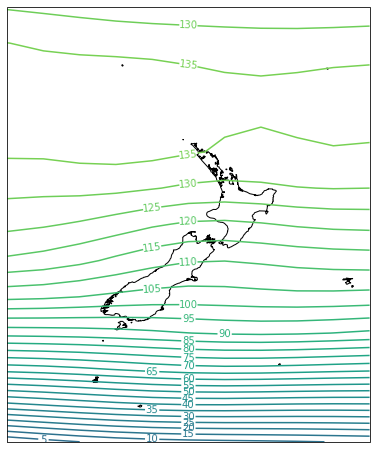

In [23]:
f, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':proj})

ax.coastlines('10m')

c = ax.contour(lons - central_longitude, lats, dsetm['hgt'], np.arange(-100, 200, 5))

plt.clabel(c, fmt='%i')

ax.set_extent([lon.data.min() - central_longitude, lon.data.max() - central_longitude, lat.data.min(), lat.data.max()], crs=proj)

### make a function 

In [24]:
def make_map(X, lons, lats, vmin=-250, vmax=250, step=10, ax=None, central_longitude=180., fmt='%i'): 
    
    from numpy import ma
    
    if not(ax): 
        central_longitude = 180.
        proj = ccrs.PlateCarree(central_longitude=central_longitude)
        f, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':proj})
        
    proj = ccrs.PlateCarree(central_longitude=central_longitude)
    
    ax.coastlines('10m')
            
    if X.min() < 0 and X.max() > 0: 
        p = ax.contour(lons - central_longitude, lats, ma.masked_less(X,0), np.arange(0, vmax + step, step), colors='r')
        n = ax.contour(lons - central_longitude, lats, ma.masked_greater(X,0), np.arange(vmin, 0, step), colors='b')
        
        ax.contour(lons - central_longitude, lats, X, np.array([0]), colors='k')
        
        plt.clabel(p, fmt=fmt)
        plt.clabel(n, fmt=fmt) 
    elif X.min() < 0 and X.max() < 0: 
        n = ax.contour(lons - central_longitude, lats, X, np.arange(vmin, vmax + step, step), colors='b')
        plt.clabel(n, fmt=fmt)
    else: 
        p = ax.contour(lons - central_longitude, lats, X, np.arange(vmin, vmax + step, step), colors='r')
        plt.clabel(p, fmt=fmt)        
                            
    ax.set_extent([lon.data.min() - central_longitude, lon.data.max() - central_longitude, lat.data.min(), lat.data.max()], crs=proj)

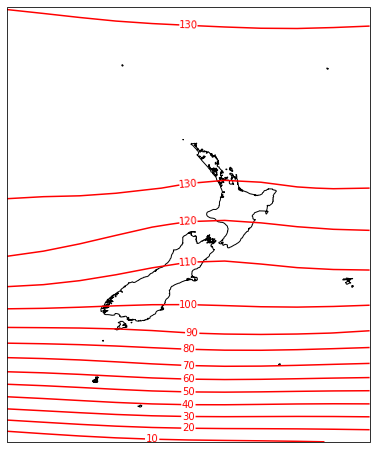

In [25]:
make_map(dsetm['hgt'].data, lons, lats)

In [26]:
dset

,Array,Chunk
Bytes,8.25 MB,209.35 kB
Shape,"(14426, 13, 11)","(366, 13, 11)"
Count,160 Tasks,40 Chunks
Type,float32,numpy.ndarray


In [27]:
hgt = dset['hgt']

In [28]:
hgt

,Array,Chunk
Bytes,8.25 MB,209.35 kB
Shape,"(14426, 13, 11)","(366, 13, 11)"
Count,160 Tasks,40 Chunks
Type,float32,numpy.ndarray


### we now need to go from 3D (time, lat, lon) to 2D (time, space [lat X lon]) to perform the PCA (EOF) analyis

In [29]:
hgt_stacked = hgt.stack(latlon=('lat', 'lon'))

In [30]:
hgt_stacked

<xarray.DataArray 'hgt' (time: 14426, latlon: 143)>
dask.array<reshape, shape=(14426, 143), dtype=float32, chunksize=(366, 143), chunktype=numpy.ndarray>
Coordinates:
    level    float32 1000.0
  * time     (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1997-06-30
  * latlon   (latlon) MultiIndex
  - lat      (latlon) float64 -25.0 -25.0 -25.0 -25.0 ... -55.0 -55.0 -55.0
  - lon      (latlon) float64 160.0 162.5 165.0 167.5 ... 180.0 182.5 185.0
Attributes:
    long_name:     mean Daily Geopotential height
    units:         m
    precision:     0
    GRIB_id:       7
    GRIB_name:     HGT
    var_desc:      Geopotential height
    dataset:       NCEP Reanalysis Daily Averages
    level_desc:    Multiple levels
    statistic:     Mean
    parent_stat:   Individual Obs
    actual_range:  [ -475. 32282.]
    valid_range:   [ -700. 35000.]

In [31]:
hgt.shape

(14426, 13, 11)

In [32]:
hgt_stacked.shape

(14426, 143)

In [33]:
type(hgt_stacked.data)

dask.array.core.Array

### we now need to LOAD the dataset in memory in order to perform the PCA (EOF analysis)

In [34]:
hgt_stacked.load()

<xarray.DataArray 'hgt' (time: 14426, latlon: 143)>
array([[ 84.,  92., 101., ..., -22., -39., -64.],
       [ 97.,  97.,  97., ...,  57.,  61.,  65.],
       [108., 105., 101., ...,  40.,  20.,   6.],
       ...,
       [132., 134., 135., ...,  62.,  48.,  34.],
       [125., 120., 116., ...,  31.,  23.,  14.],
       [133., 119., 106., ...,  46.,  39.,  30.]], dtype=float32)
Coordinates:
    level    float32 1000.0
  * time     (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1997-06-30
  * latlon   (latlon) MultiIndex
  - lat      (latlon) float64 -25.0 -25.0 -25.0 -25.0 ... -55.0 -55.0 -55.0
  - lon      (latlon) float64 160.0 162.5 165.0 167.5 ... 180.0 182.5 185.0
Attributes:
    long_name:     mean Daily Geopotential height
    units:         m
    precision:     0
    GRIB_id:       7
    GRIB_name:     HGT
    var_desc:      Geopotential height
    dataset:       NCEP Reanalysis Daily Averages
    level_desc:    Multiple levels
    statistic:     Mean
    parent_stat:   Individual Obs
    actual_range:  [ -475. 32282.]
    valid_range:   [ -700. 35000.]

In [35]:
type(hgt_stacked.data)

numpy.ndarray

In [36]:
X = hgt_stacked.data

In [37]:
X.shape

(14426, 143)

In [38]:
type(X)

numpy.ndarray

The number of variables (features) is 143 (13 points in latitude * 11 points in longitude): while we can attend to perform our cluster analysis directly on this matrix, 
it is expensive computationally, i.e. each day (observation) is associated to a point with 143 coordinates, we need to find clusters in 143 dimensions ...

The approach generally taken is to **reduce the dimensionality** of the original dataset using methods such as [Principal Component (or Empirical Orthoginal Function) Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis). This is the approach that has been used by Kidson, and we will try and follow the way he processed the data as described in the paper.

## do PCA / EOF analysis of daily geopotential fields

To perform the PCA, we will use the excellent (not enough superlatives here !) [scikit-learn](http://scikit-learn.org/) Machine Learning library  

**Scikit-learn** implements a wide array of [supervised](http://en.wikipedia.org/wiki/Supervised_learning) and [unsupervised](http://en.wikipedia.org/wiki/Unsupervised_learning) Machine Learning algorithms, 

**Unsupervised** refers to algorithms which learn from a training set of unlabeled examples, using the features of the inputs to categorize inputs together according to some statistical criteria.

Unsupervised learning algorithms are usually separated into :

+ [Dimensionality reduction](http://scikit-learn.org/stable/modules/decomposition.html#decompositions) , whicn *learns* a more compact representation  of the data (i.e. reducing the dimensions).

+ [Clustering](http://scikit-learn.org/stable/modules/clustering.html#clustering)


scikit-learn exposes a very useful [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) submodule, which allows to do various transformations on your input data, in this case we will *standardisation* the dataset, removing the mean and dividing by the standard deviation ... 

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
scaler  = StandardScaler()

In [41]:
scaler = scaler.fit(X)

In [42]:
X = scaler.transform(X)

In [43]:
X.shape

(14426, 143)

In [44]:
X.mean(0)

array([ 1.61439914e-07, -7.60324852e-08,  1.35418148e-07, -8.01972959e-08,
        4.20281729e-08, -2.97816634e-08,  5.58612800e-09,  7.15454078e-08,
        9.96578464e-09, -2.94490583e-08, -5.50545529e-08,  1.06309965e-08,
        3.61296856e-07, -4.41436327e-08, -3.94995432e-08,  5.86378164e-08,
        6.38934026e-08,  2.54515875e-08, -6.69178419e-08,  1.98737240e-08,
        2.48483527e-08,  1.79844815e-08, -3.83095973e-08,  1.30976519e-08,
       -1.98043111e-07,  1.24200440e-07, -6.96613256e-08, -6.79920973e-08,
       -2.57986557e-08, -1.42793326e-07,  2.24436736e-08,  1.56841278e-08,
       -4.16418544e-08, -2.01920756e-07, -8.21474799e-08,  2.81454895e-08,
       -2.65258429e-08, -1.45933461e-08, -4.46890240e-08, -4.62921435e-08,
        8.74278570e-08, -8.77997124e-08, -1.45755791e-07,  3.26196599e-08,
        9.18054468e-08,  1.47462202e-08,  3.73923505e-08, -4.25983551e-08,
        1.32216038e-09, -1.85102458e-08, -8.88326568e-09,  9.09811604e-09,
        8.05278333e-09, -

In [45]:
X.mean()

8.284306e-10

In [46]:
X.std(0)

array([0.9999997 , 1.0000002 , 1.0000026 , 1.0000006 , 1.0000062 ,
       0.99999726, 1.0000011 , 0.9999926 , 1.0000044 , 0.9999942 ,
       0.999993  , 0.9999942 , 0.9999952 , 1.0000063 , 0.99999356,
       0.99998903, 1.0000035 , 0.999995  , 1.0000031 , 1.0000038 ,
       1.0000074 , 0.99999595, 0.99999976, 1.0000015 , 1.        ,
       0.999999  , 1.0000129 , 0.99999213, 1.000001  , 0.99999803,
       1.0000004 , 0.9999942 , 0.9999987 , 0.99999416, 0.99999297,
       0.9999968 , 0.99998975, 0.9999963 , 0.9999989 , 1.0000042 ,
       1.0000056 , 1.0000012 , 1.0000005 , 0.9999965 , 0.99999845,
       1.0000045 , 1.0000069 , 0.99999976, 0.9999983 , 1.0000019 ,
       0.99999225, 0.9999913 , 0.99999297, 1.0000055 , 1.0000001 ,
       0.9999981 , 0.99999475, 1.0000049 , 0.99999607, 0.9999977 ,
       0.9999973 , 1.        , 1.0000052 , 1.0000026 , 1.0000026 ,
       1.0000048 , 1.        , 1.0000036 , 1.0000052 , 0.99999416,
       1.0000011 , 1.0000042 , 1.0000004 , 1.0000006 , 0.99999

### The pca class itself is in the *decomposition* submodule of scikit-learn

In [47]:
from sklearn.decomposition import pca

/nesi/nobackup/niwa00013/williamsjh/miniconda3/envs/kidson2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [48]:
skpca = pca.PCA()

In [49]:
skpca.fit(X)

PCA()

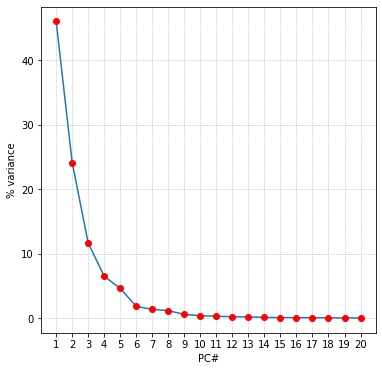

In [50]:
f, ax = plt.subplots(figsize=(6,6))
ax.plot(range(1,21), skpca.explained_variance_ratio_[0:20]*100)
ax.plot(range(1,21), skpca.explained_variance_ratio_[0:20]*100,'ro')
ax.grid(ls=':')
ax.set_xticks(range(1,21)); 
ax.set_xlabel('PC#');
ax.set_ylabel("% variance");

### In his paper, Kidson keeps the first 5 Principal Components and perform the cluster analysis on the subspace spanned by these 5 PCs

In [51]:
ipc = 5

In [52]:
skpca.explained_variance_ratio_[:ipc].sum()

0.92957884

Together they explain more than 90% of the total variance contained in the dataset

In [53]:
PCs = skpca.transform(X)

In [54]:
PCs = PCs[:,:ipc]

### the EOFS contain the spatial patterns associated with each PC

In [55]:
EOFs = skpca.components_

In [56]:
EOFs = EOFs[:ipc,:]

In [57]:
EOFs.shape

(5, 143)

In [58]:
EOFs_r = EOFs.reshape((ipc, len(lat), len(lon)))

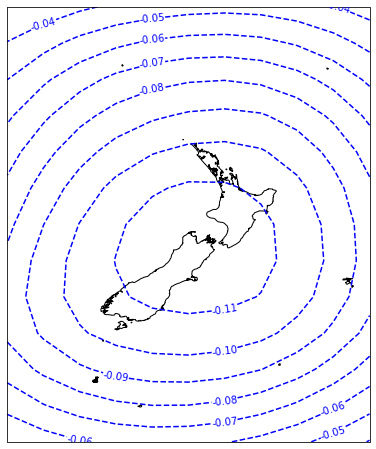

In [59]:
make_map(EOFs_r[0,:,:], lons, lats, vmin=-0.2, vmax=0.2, step=0.010, fmt='%4.2f')

In his paper, not clear whether Kidson *scaled* (standardised) the PCs or not, trying with and without standardisation seem to indicated he DID NOT standardise the PCs prior to the cluster analysis

In [60]:
# scaler_PCs = StandardScaler()
# scaler_PCs.fit(PCs)
# PCs_std = scaler_PCs.transform(PCs)

In [68]:
PCdf = pd.DataFrame(PCs, columns = ["PC%s" % (x) for x in range(1, PCs.shape[1] +1)])

In [69]:
#PCdf = pd.DataFrame(PCs, index = dset['time'], \
#                    columns = ["PC%s" % (x) for x in range(1, PCs.shape[1] +1)])

In [70]:
PCdf.head()

,PC1,PC2,PC3,PC4,PC5
0,6.543113,0.855012,-0.263123,1.142339,0.382615
1,3.433749,0.999204,-3.576155,1.231995,0.973347
2,3.250841,0.404696,-2.427313,0.777031,0.843236
3,4.769243,1.066432,-2.498721,-1.622930,0.601026
4,6.530817,0.986452,-4.493587,-3.818093,0.654021


In [71]:
PCdf.tail()

,PC1,PC2,PC3,PC4,PC5
14421,-12.598288,-2.727667,-2.329991,-0.190079,5.302011
14422,-11.488331,-1.277161,-2.327297,1.154985,5.969668
14423,-10.283318,3.672688,0.561113,-0.142917,5.680111
14424,-6.354342,7.259837,3.595382,1.509178,5.147993
14425,0.149310,10.819013,-1.595996,1.459566,1.896386


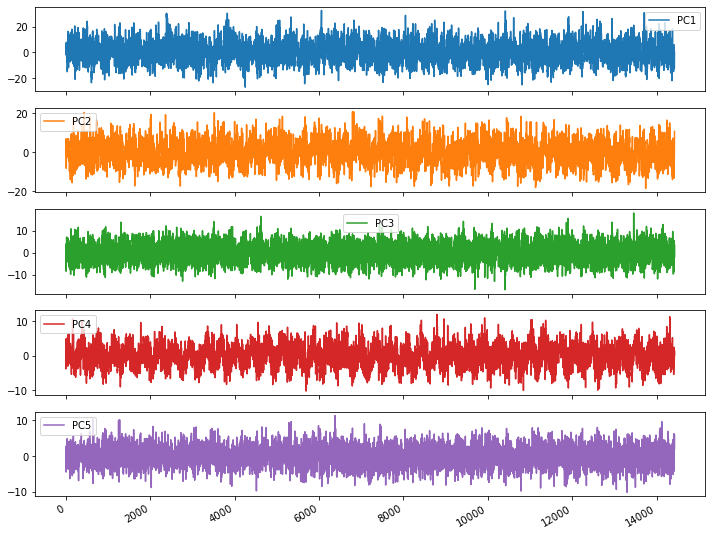

In [72]:
PCdf.plot(subplots=True, figsize=(12,10));

### The K-means clustering class is found in the [clustering](http://scikit-learn.org/stable/modules/clustering.html#clustering) submodule of scikit-learn

In [80]:
from sklearn.cluster import KMeans

#### specify the number of clusters here ... 

In [81]:
nclusters = 12

#### initialise the KMeans class with the parameters, n_jobs=-1 means the computations will be distributed accross the cores of your machine (if you have a multicore CPU)

In [82]:
kmeans = KMeans(init='k-means++', n_clusters=nclusters, n_init=10, n_jobs=-1)

#### fit ... 

In [83]:
kmeans.fit(PCdf.values)

/nesi/nobackup/niwa00013/williamsjh/miniconda3/envs/kidson2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:973: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=12, n_jobs=-1)

#### `kmeans.labels_` contains the unique labels for each day: i.e. a number from 0 to nclusters-1 indicating to which cluster (regime) each day belongs

In [84]:
kmeans.labels_

array([6, 7, 7, ..., 4, 4, 0], dtype=int32)

In [85]:
np.unique(kmeans.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

#### we put that into a Pandas DataFrame and assign the corresponding date to each day 

In [101]:
timeindex = time.to_index()

In [104]:
labels = pd.DataFrame(kmeans.labels_, timeindex, columns=['cluster'])

In [105]:
labels.head()

,cluster
time,
1958-01-01,6
1958-01-02,7
1958-01-03,7
1958-01-04,11
1958-01-05,11


In [106]:
c = 0

In [107]:
index = labels.query('cluster == {}'.format(c))

In [108]:
nbdays = len(index)

In [109]:
nbdays

1189

In [110]:
cluster = dset.sel(time=index.index).mean('time')

In [111]:
cluster

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 11)
Coordinates:
    level    float32 1000.0
  * lon      (lon) float32 160.0 162.5 165.0 167.5 ... 177.5 180.0 182.5 185.0
  * lat      (lat) float32 -25.0 -27.5 -30.0 -32.5 ... -47.5 -50.0 -52.5 -55.0
Data variables:
    hgt      (lat, lon) float32 dask.array<chunksize=(13, 11), meta=np.ndarray>

In [112]:
clusters = []
nbdays = []
for c in range(nclusters): 
    index = labels.query('cluster == {}'.format(c)) 
    nbdays.append(len(index))
    cluster = dset.sel(time=index.index).mean('time')
    clusters.append(cluster)

In [113]:
clusters = xr.concat(clusters, dim='cluster')

In [114]:
clusters

<xarray.Dataset>
Dimensions:  (cluster: 12, lat: 13, lon: 11)
Coordinates:
    level    float32 1000.0
  * lon      (lon) float32 160.0 162.5 165.0 167.5 ... 177.5 180.0 182.5 185.0
  * lat      (lat) float32 -25.0 -27.5 -30.0 -32.5 ... -47.5 -50.0 -52.5 -55.0
Dimensions without coordinates: cluster
Data variables:
    hgt      (cluster, lat, lon) float32 dask.array<chunksize=(1, 13, 11), meta=np.ndarray>

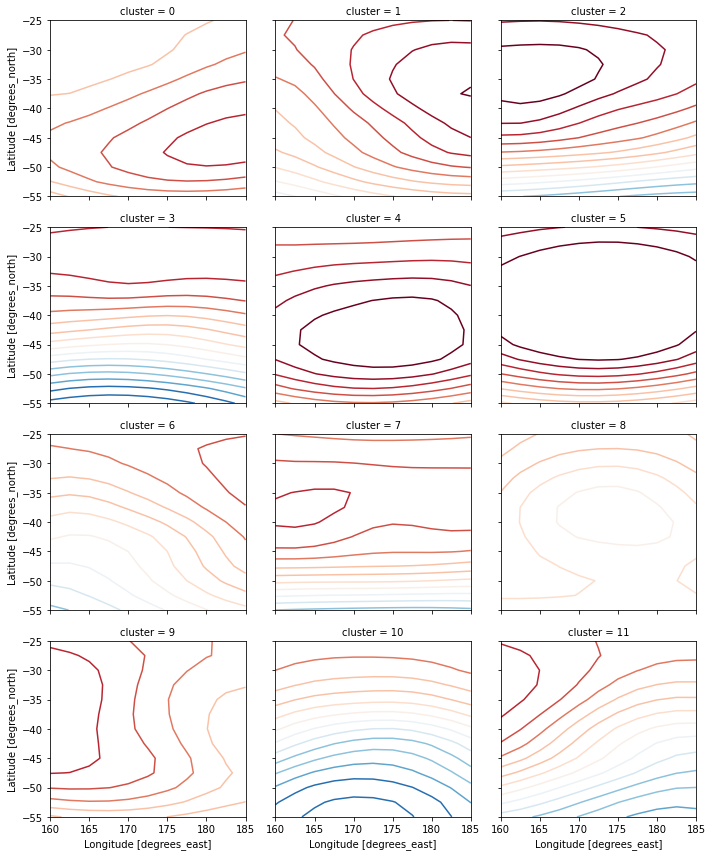

In [115]:
f = clusters['hgt'].plot.contour(x='lon', y='lat', col='cluster', col_wrap=3, levels=np.arange(-150,200,20))

In [116]:
sum(nbdays)

14426

/nesi/nobackup/niwa00013/williamsjh/miniconda3/envs/kidson2/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


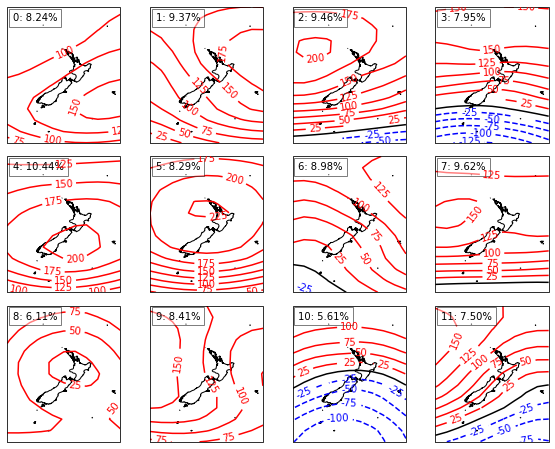

In [122]:
f, axes = plt.subplots(nrows=3, ncols=4, figsize=(10,8), subplot_kw={'projection':proj})
f.subplots_adjust(wspace=0.1, hspace=0.1)
axes = axes.flatten() 
for c in range(nclusters): 
    ax = axes[c]
    clus = clusters.sel(cluster=c)
    make_map(clus['hgt'], lons, lats, step=25, ax=ax)
    ax.text(0.05, 0.9, "{}: {:3.2f}%".format(c, nbdays[c] / sum(nbdays) * 100), transform=ax.transAxes, bbox=dict(facecolor='w', alpha=0.5))

In [123]:
f.savefig('./images/Kidson_clusters.png', dpi=200)

In [124]:
!open ./images/Kidson_Archetypes.png

Couldn't get a file descriptor referring to the console


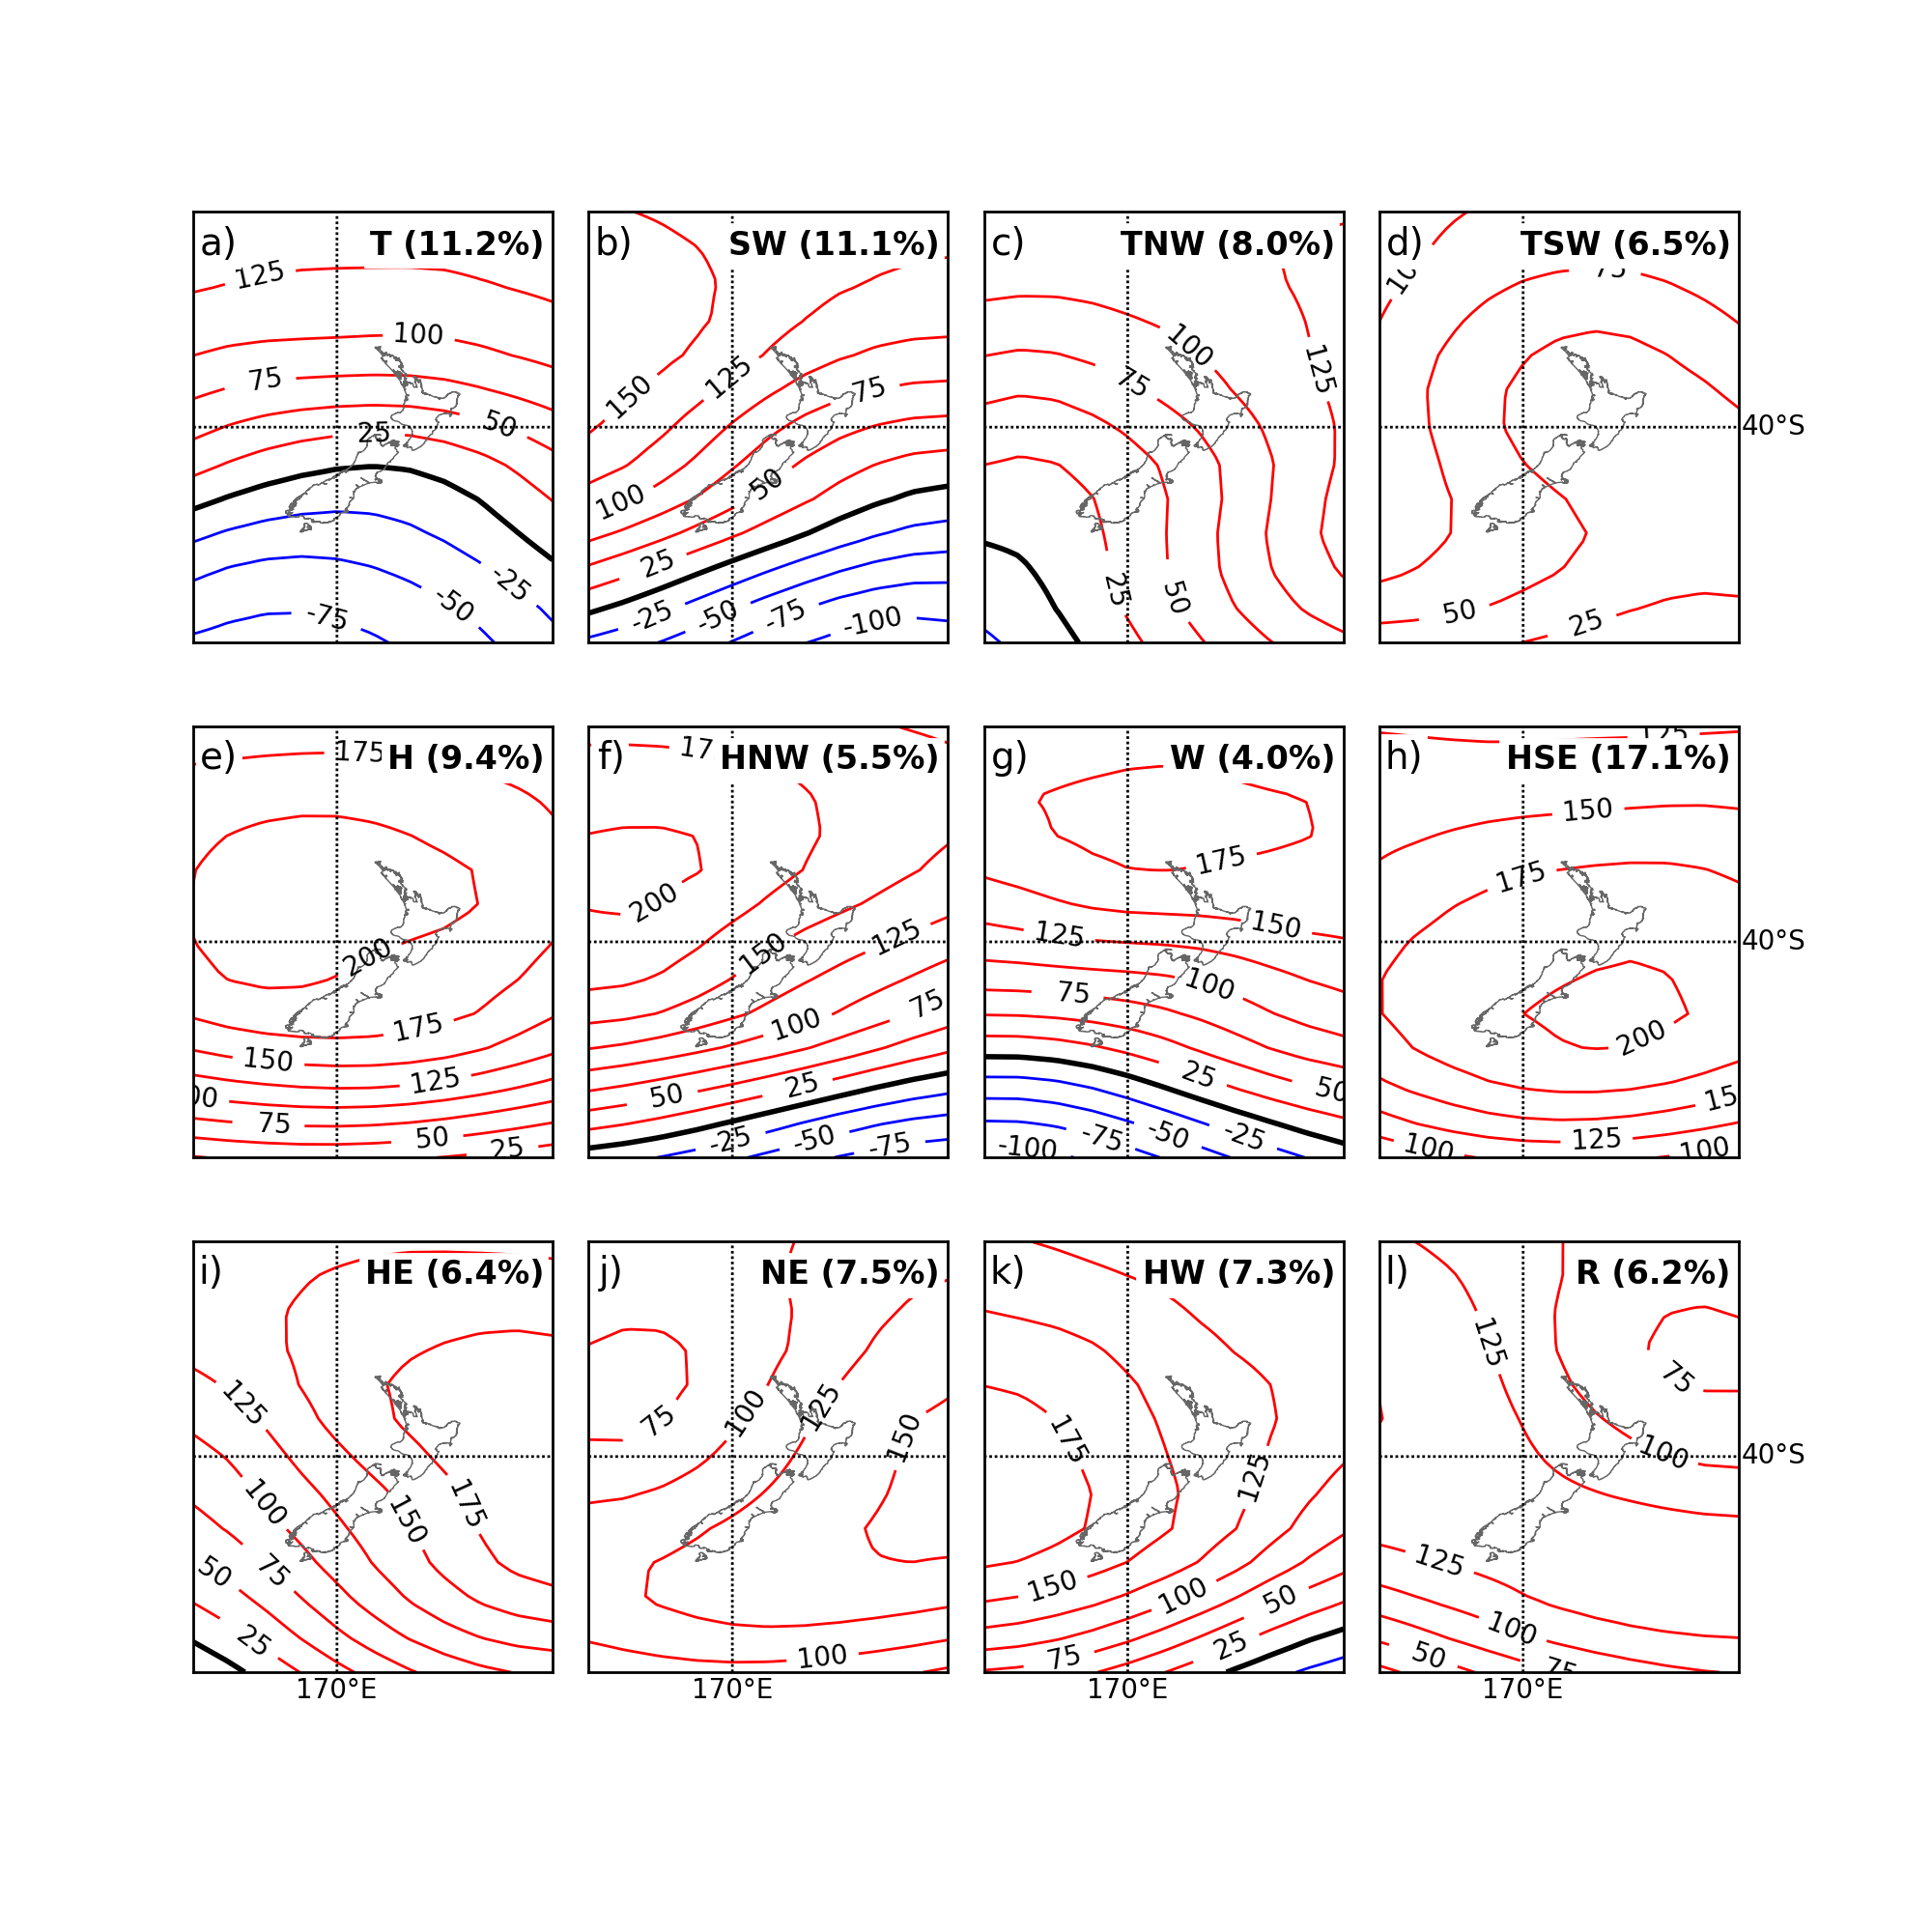

In [125]:
Image('./images/Kidson_Archetypes.png', width=700)

### look at the seasonal distribution of the synoptic types / weather regimes

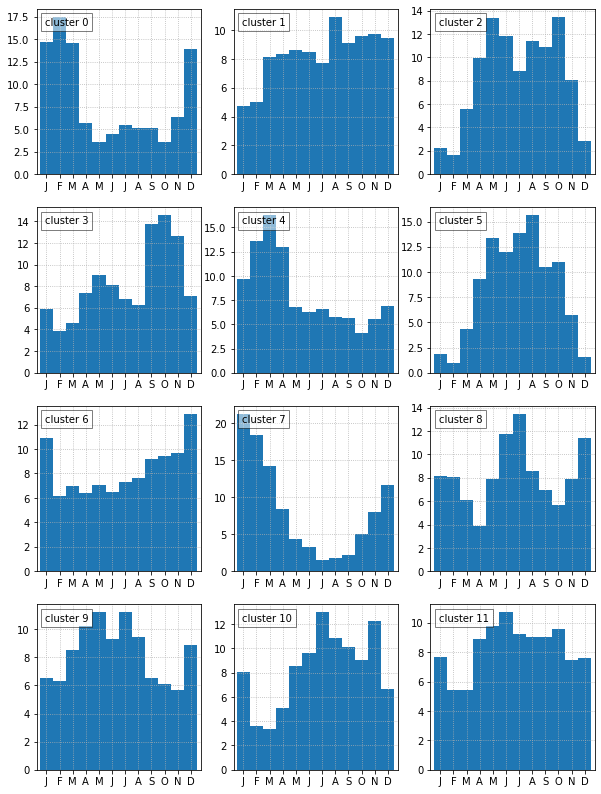

In [126]:
f, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,14))
axes = axes.flatten() 
for c in range(nclusters): 
    ax = axes[c]
    cf = labels.query('cluster == {}'.format(c))
    # in percentage
    ((cf.groupby(cf.index.month).count()) / len(cf) * 100).plot(kind='bar', width=1, ax=ax, legend=None)
    # in number of days
#     cf.groupby(cf.index.month).count().plot(kind='bar', width=1, ax=ax, legend=None)
    ax.set_ylim(0, None)
    ax.grid(ls=':')
    ax.text(0.05, 0.9, 'cluster {}'.format(c), transform=ax.transAxes, bbox=dict(facecolor='w', alpha=0.5))
    ax.set_xticklabels(list('JFMAMJJASOND'), rotation=0)
    ax.set_xlabel('')